In [1]:
from __future__ import print_function
import time 
import requests
import cv2
import operator
import numpy as np
from PIL import Image
from io import BytesIO

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [2]:
# Variables
_region = 'eastus' #Here you enter the region of your subscription
_url = 'https://{}.api.cognitive.microsoft.com/vision/v2.0/analyze'.format(_region)
_key = "858fc8fe6db94281aa5b8f3af064ed68" #Here you have to paste your primary key
_maxNumRetries = 10 #최대 재시도 횟수

In [3]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

In [4]:
def renderResultOnImage( result, img ):
    
    """Azure로 부터 얻은 결과물을 이미지 위에 Text로 입력해 주는 함수"""

    R = int(result['color']['accentColor'][:2],16) #Red
    G = int(result['color']['accentColor'][2:4],16) #Green
    B = int(result['color']['accentColor'][4:],16) #Blue

    cv2.rectangle( img,(0,0), (img.shape[1], img.shape[0]), color = (R,G,B), thickness = 25 ) #사진 위 사각 프레임

    if 'categories' in result:
        categoryName = sorted(result['categories'], key=lambda x: x['score'])[0]['name']
        cv2.putText( img, categoryName, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3 )

{'categories': [{'name': 'trans_trainstation', 'score': 0.98828125}], 'color': {'dominantColorForeground': 'Black', 'dominantColorBackground': 'Black', 'dominantColors': ['Black'], 'accentColor': '484B83', 'isBwImg': False, 'isBWImg': False}, 'requestId': '51ad1ca5-049f-4433-bf5b-37f8da581b17', 'metadata': {'width': 1500, 'height': 1155, 'format': 'Jpeg'}}


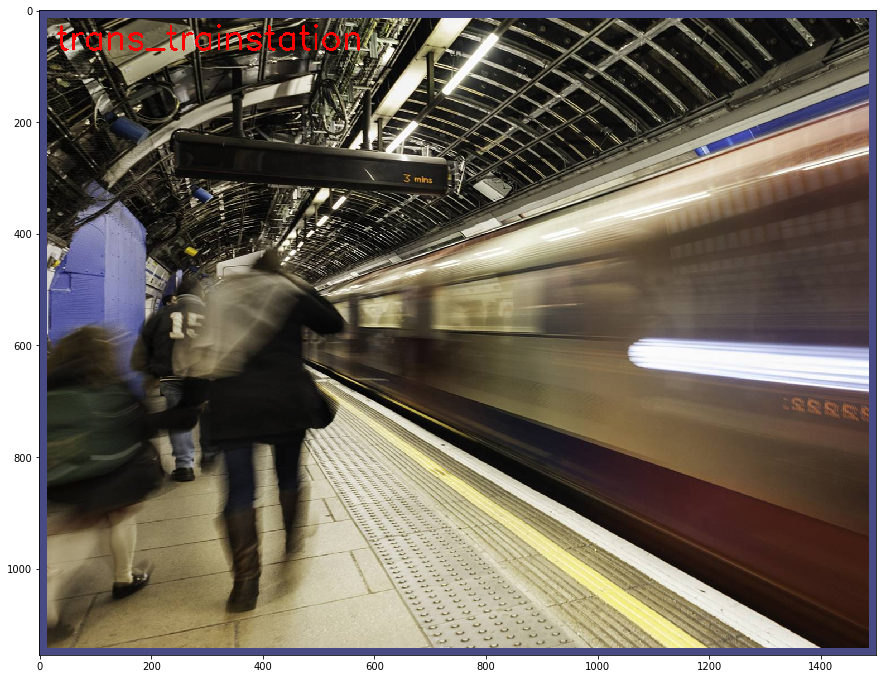

In [5]:
# URL direction to image
urlImage = 'https://oxfordportal.blob.core.windows.net/vision/Analysis/3.jpg' #가져오고자 하는 사진의 URL 주소

# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories'}  #파라미터 설정

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key #전송에 key 입력
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None

result = processRequest( json, data, headers, params )
print(result)
if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB ) 

    renderResultOnImage( result, img ) #이미지 위 TEXT Write

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )


c:\users\administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


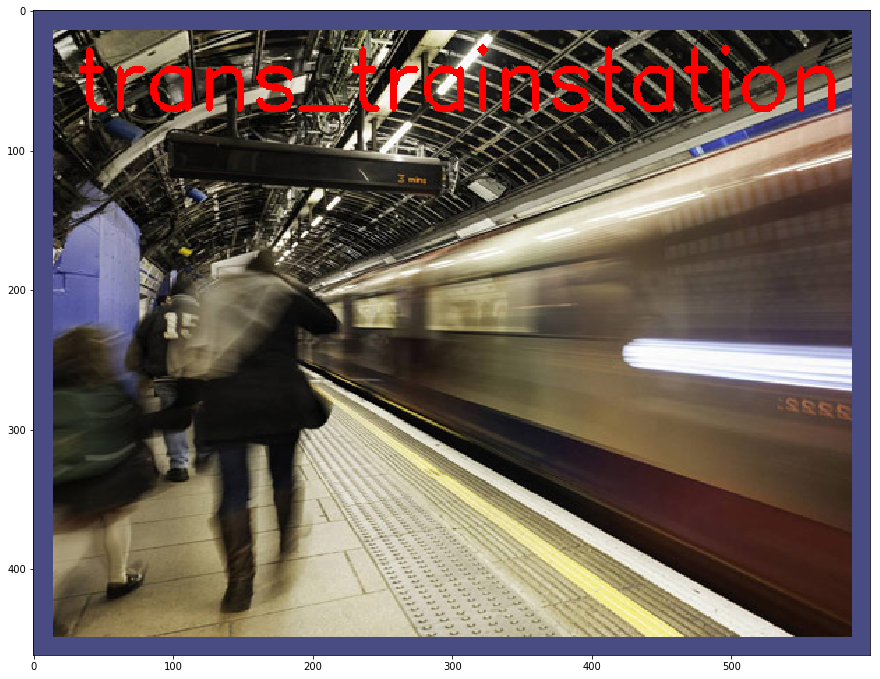

In [6]:
# Load raw image file into memory
image_path = r'./다운로드.jpg'
with open( image_path, 'rb' ) as f:
    data = f.read()
    
# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )


{'categories': [{'name': 'trans_trainstation', 'score': 0.98828125}], 'color': {'dominantColorForeground': 'Black', 'dominantColorBackground': 'Black', 'dominantColors': ['Black'], 'accentColor': '484C83', 'isBwImg': False, 'isBWImg': False}, 'description': {'tags': ['train', 'platform', 'station', 'building', 'indoor', 'subway', 'track', 'walking', 'waiting', 'pulling', 'board', 'people', 'man', 'luggage', 'standing', 'holding', 'large', 'woman', 'yellow', 'suitcase'], 'captions': [{'text': 'people waiting at a train station', 'confidence': 0.8330993278560295}]}, 'requestId': '139afa17-39d7-40e2-a620-5ff01957b947', 'metadata': {'width': 600, 'height': 462, 'format': 'Jpeg'}}


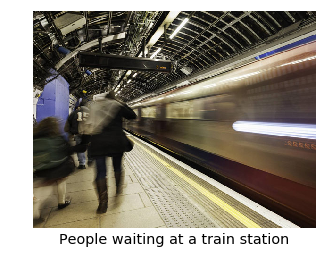

In [7]:
image_data = open(image_path, "rb").read()
headers    = {'Ocp-Apim-Subscription-Key': _key,
              'Content-Type': 'application/octet-stream'}
params     = {'visualFeatures': 'Categories,Description,Color'}
response = requests.post(_url, headers=headers, params=params, data=image_data)
response.raise_for_status()
# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.

result = response.json()
print(result)
image_caption = result["description"]["captions"][0]["text"].capitalize() #사진에 대한 설명

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(image_data))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()